# Visualisation
## Visualisations Seaborn
### Chargement des données

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

df_conso_enrichies = pd.read_parquet("../output/consommations_enrichies.parquet")

df_conso_enrichies.info()
df_conso_enrichies.head()
df_conso_enrichies['date'] = pd.to_datetime(df_conso_enrichies['date'])

df_conso_enrichies.head(10)


# "classe_energique" n'est pas dans mon dataframe, je la rajoute donc manuellement avec une jointure sur batiment_id 

df_bat_brut = pd.read_csv("../data_ecf/batiments.csv")

df_bat_light = df_bat_brut[['batiment_id', 'classe_energetique']] 

df_conso_enrichies = df_conso_enrichies.merge(df_bat_light, on='batiment_id', how='left')

print("La colonne classe_energetique a été réintégrée !")

<class 'pandas.DataFrame'>
RangeIndex: 10620788 entries, 0 to 10620787
Data columns (total 32 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   type_energie             str           
 1   batiment_id              str           
 2   unite                    str           
 3   hour                     int32         
 4   year                     int32         
 5   month                    int32         
 6   conso_mean               float64       
 7   conso_min                float64       
 8   conso_max                float64       
 9   measurement_count        int64         
 10  date                     object        
 11  timestamp_hour           datetime64[ns]
 12  surface_m2               int32         
 13  nb_occupants_moyen       int32         
 14  type                     str           
 15  nom                      str           
 16  commune                  str           
 17  temperature_c            float64    

### Pairplot des consommations par saison

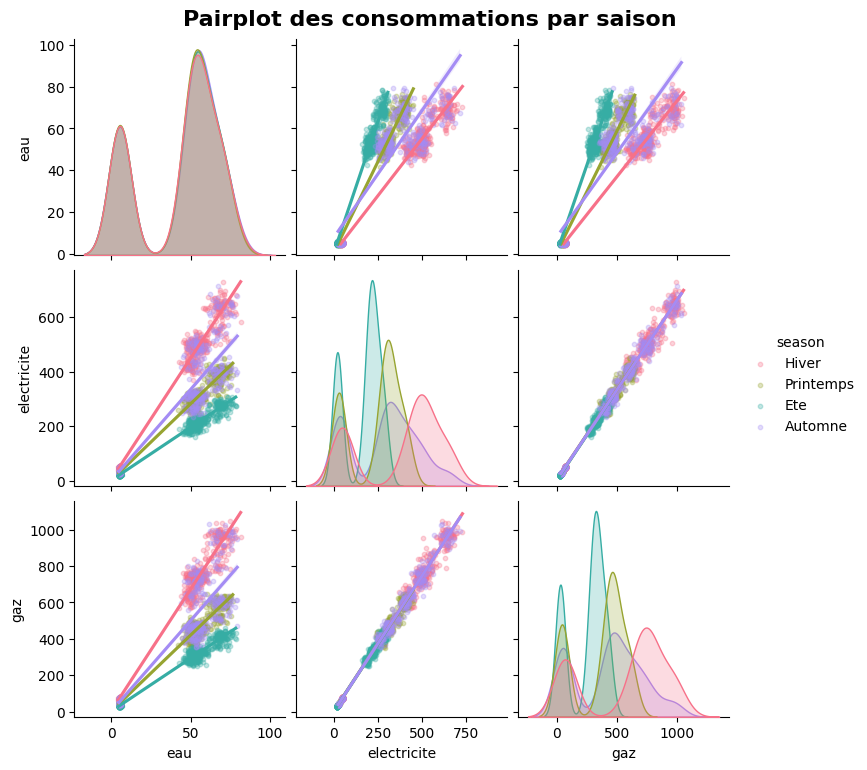

In [ ]:
df_grouped = df_conso_enrichies.groupby(['month', 'day_of_week', 'hour', 'season', 'type_energie'])['conso_mean'].mean().unstack()


df_pp_final = df_grouped.reset_index()


cols_energies = [c for c in ['eau', 'electricite', 'gaz'] if c in df_pp_final.columns]
df_pp_final = df_pp_final[cols_energies + ['season']]


g = sns.pairplot(
    df_pp_final.dropna(), 
    hue='season', 
    kind="reg", 
    diag_kind="kde", 
    palette="husl",
    plot_kws={'scatter_kws': {'alpha': 0.3, 's': 10}}
)

g.fig.suptitle("Pairplot des consommations par saison", y=1.02, fontsize=16, fontweight="bold")
plt.show()

### Violin plot de la consommation électrique par type de bâtiment

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6748\3194524901.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_conso_electrique,


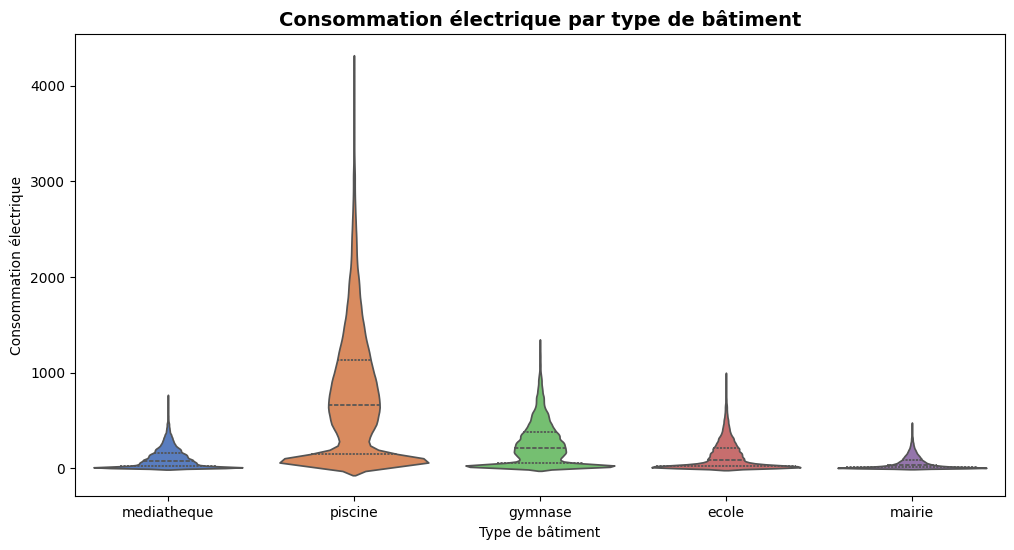

In [19]:
df_conso_electrique = df_conso_enrichies[df_conso_enrichies["type_energie"] == "electricite"]


plt.figure(figsize=(12, 6))
sns.violinplot(data=df_conso_electrique, 
               x="type", 
               y="conso_mean", 
               palette="muted", 
               inner="quartile"
               )

# plt.ylim(0, 300)

plt.title("Consommation électrique par type de bâtiment", fontsize=14, fontweight="bold")
plt.xlabel("Type de bâtiment")
plt.ylabel("Consommation électrique")

plt.show()

### Heatmap annotée de la matrice de correlation complète

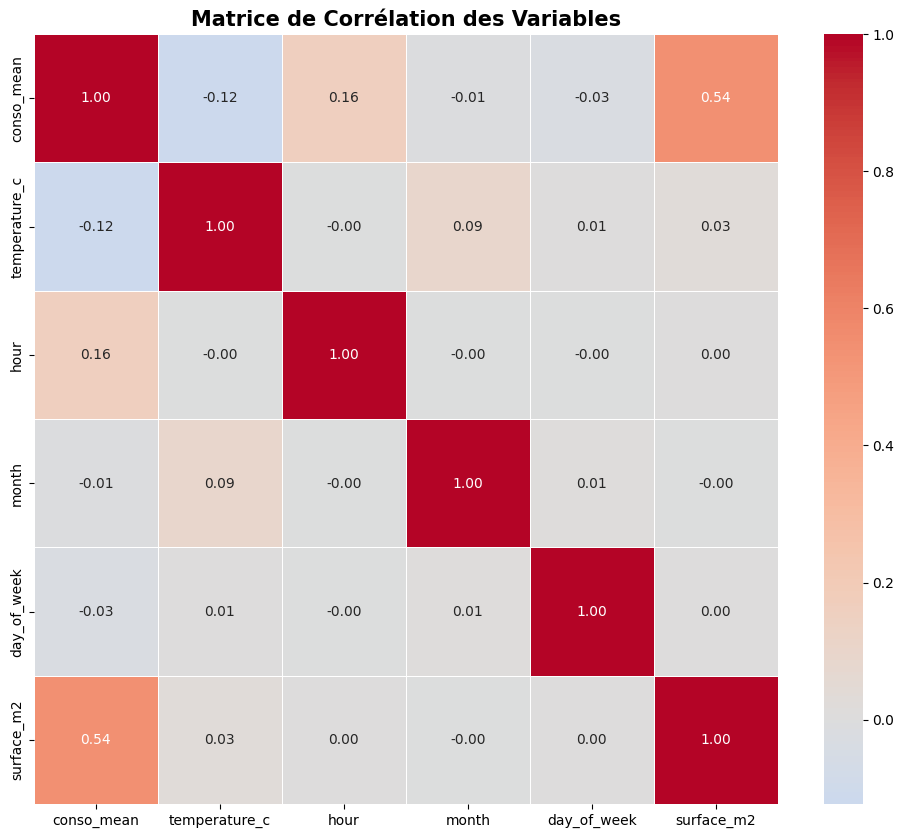

In [ ]:
cols_corr = [
    'conso_mean', 'temperature_c', 'hour', 'month', 
    'day_of_week', 'surface_m2'
]


df_corr = df_conso_enrichies[cols_corr].dropna()

corr_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))


sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    linewidths=0.5, 
    center=0
)

plt.title("Matrice de Corrélation des Variables", fontsize=15, fontweight='bold')
plt.show()

### FacetGrid : evolution mensuelle par commune (top 6 communes)

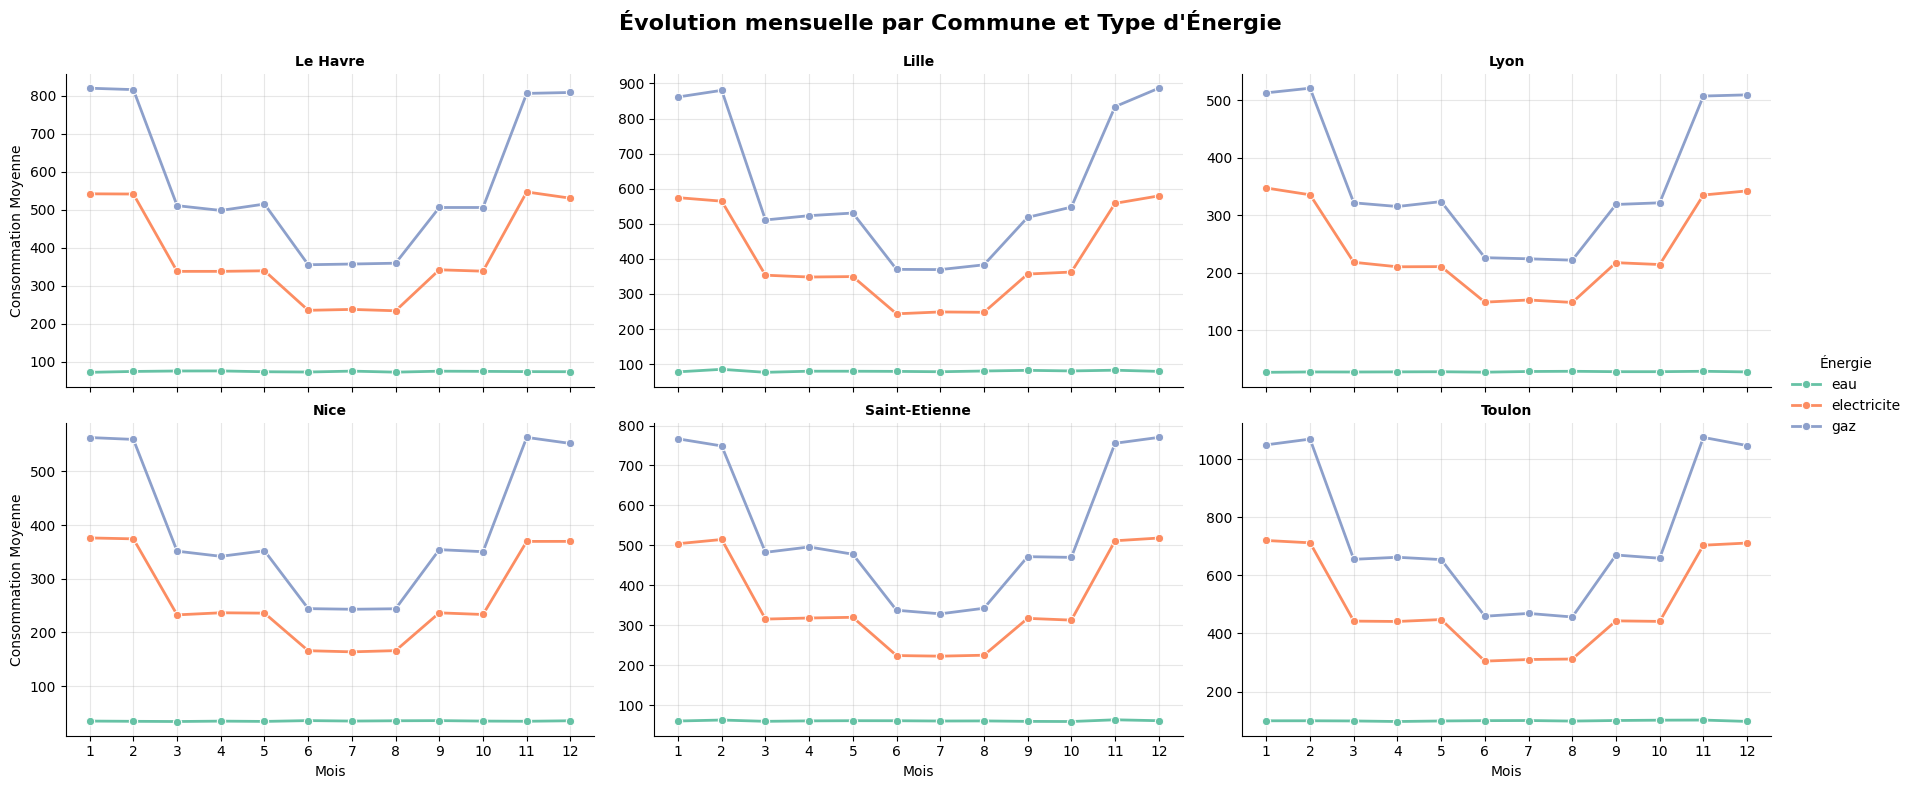

In [ ]:
top_6_communes = df_conso_enrichies.groupby('commune')['conso_mean'].sum().nlargest(6).index.tolist()

df_top6 = df_conso_enrichies[df_conso_enrichies['commune'].isin(top_6_communes)]

df_plot = df_top6.groupby(['commune', 'month', 'type_energie'])['conso_mean'].mean().reset_index()

g = sns.FacetGrid(df_plot, col="commune", hue="type_energie", 
                  col_wrap=3, height=4, aspect=1.5, sharey=False,
                  palette="Set2")


g.map(sns.lineplot, "month", "conso_mean", marker="o", linewidth=2)

g.set_axis_labels("Mois", "Consommation Moyenne")
g.set_titles(col_template="{col_name}", fontweight='bold')
g.add_legend(title="Énergie")

for ax in g.axes.flatten():
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Évolution mensuelle par Commune et Type d'Énergie", fontsize=16, fontweight='bold')

plt.show()

### Jointplot : relation surface vs consommation avec distributions marginales

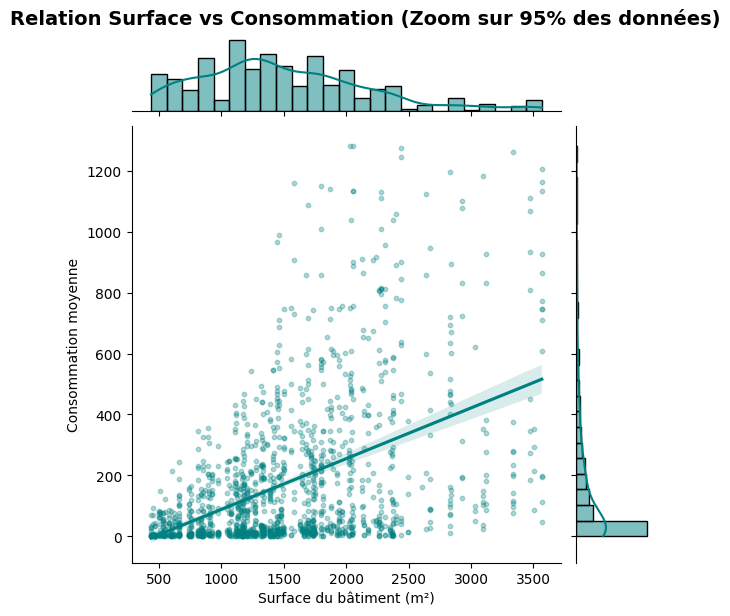

In [28]:
df_joint = df_conso_enrichies[df_conso_enrichies['conso_mean'] > 0].copy()

surface_max = df_joint['surface_m2'].quantile(0.95)
conso_max = df_joint['conso_mean'].quantile(0.95)

df_filtered = df_joint[
    (df_joint['surface_m2'] < surface_max) & 
    (df_joint['conso_mean'] < conso_max)
]

g = sns.jointplot(
    data=df_filtered.sample(min(1500, len(df_filtered))),
    x="surface_m2",
    y="conso_mean",
    kind="reg", 
    color="teal",
    marginal_kws=dict(bins=25, fill=True),
    joint_kws={'scatter_kws': {'alpha': 0.3, 's': 10}}
)

g.fig.suptitle("Relation Surface vs Consommation (Zoom sur 95% des données)", y=1.02, fontsize=14, fontweight="bold")
g.ax_joint.set_xlabel("Surface du bâtiment (m²)")
g.ax_joint.set_ylabel("Consommation moyenne")

plt.show()

### Catplot : consommation par classe energetique et type de batiment

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6748\440958771.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


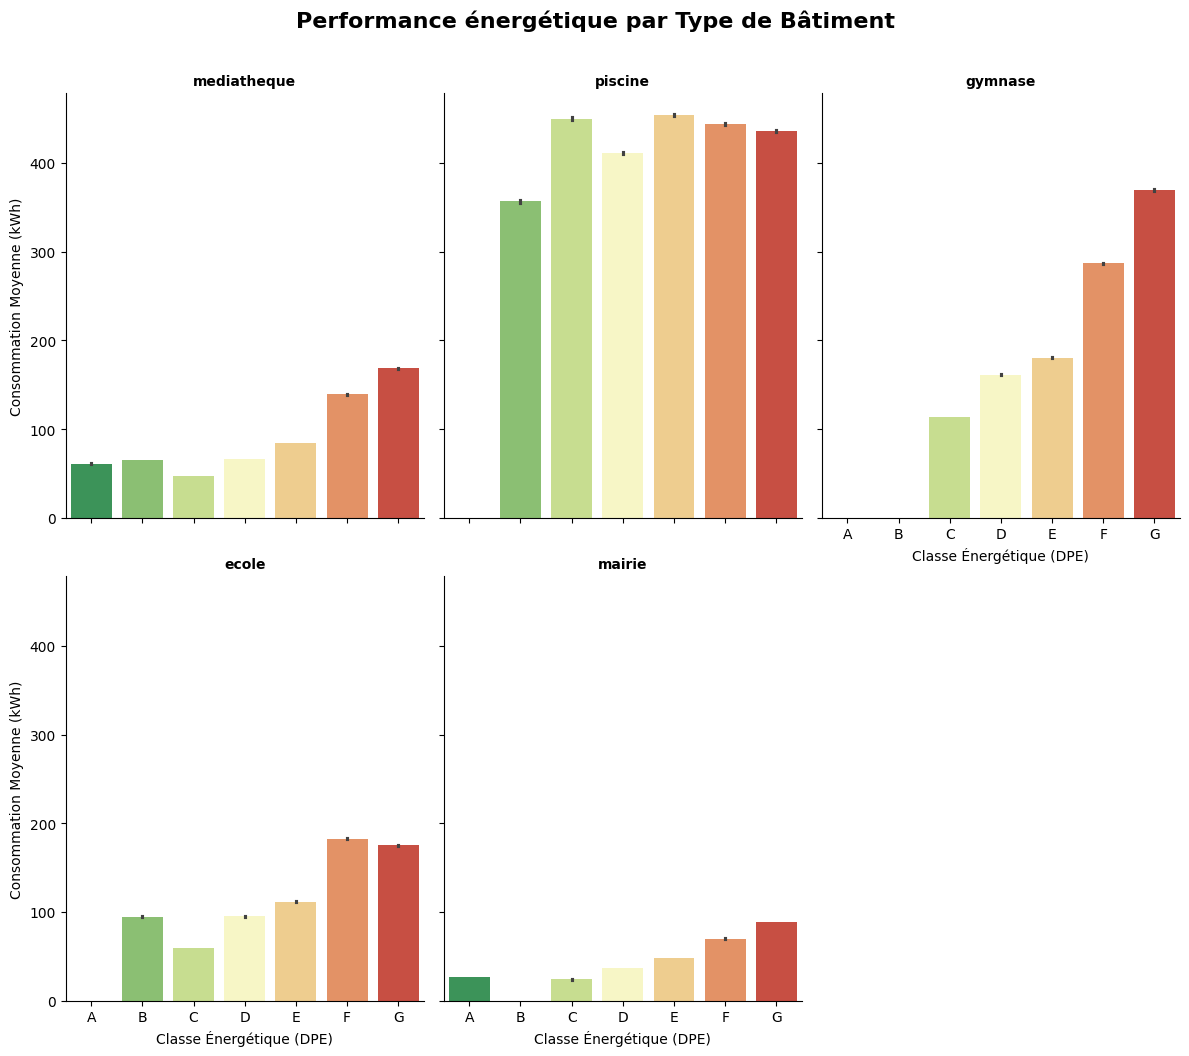

In [ ]:
ordre_dpe = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

conso_max = df_conso_enrichies['conso_mean'].quantile(0.95)
df_cat = df_conso_enrichies[df_conso_enrichies['conso_mean'] < conso_max].copy()


g = sns.catplot(
    data=df_cat, 
    x="classe_energetique", 
    y="conso_mean", 
    col="type", 
    kind="bar",
    order=ordre_dpe,
    palette="RdYlGn_r",
    height=5, 
    aspect=0.8,
    col_wrap=3 
)


g.set_axis_labels("Classe Énergétique (DPE)", "Consommation Moyenne (kWh)")
g.set_titles("{col_name}", fontweight='bold')
g.fig.suptitle("Performance énergétique par Type de Bâtiment", y=1.05, fontsize=16, fontweight='bold')

plt.show()

### Export

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6748\3230869790.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_conso_electrique,
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6748\3230869790.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g6 = sns.catplot(


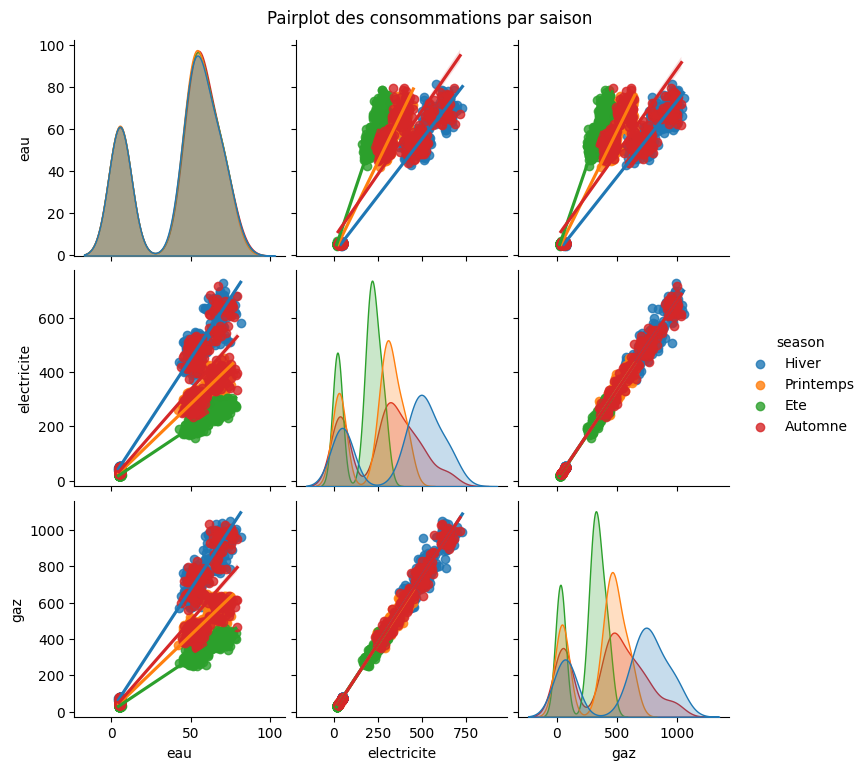

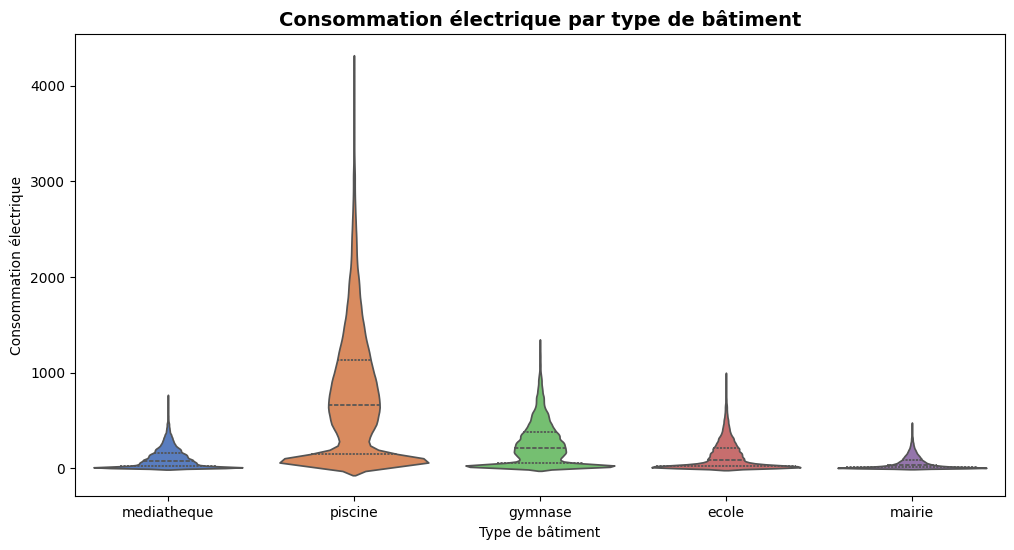

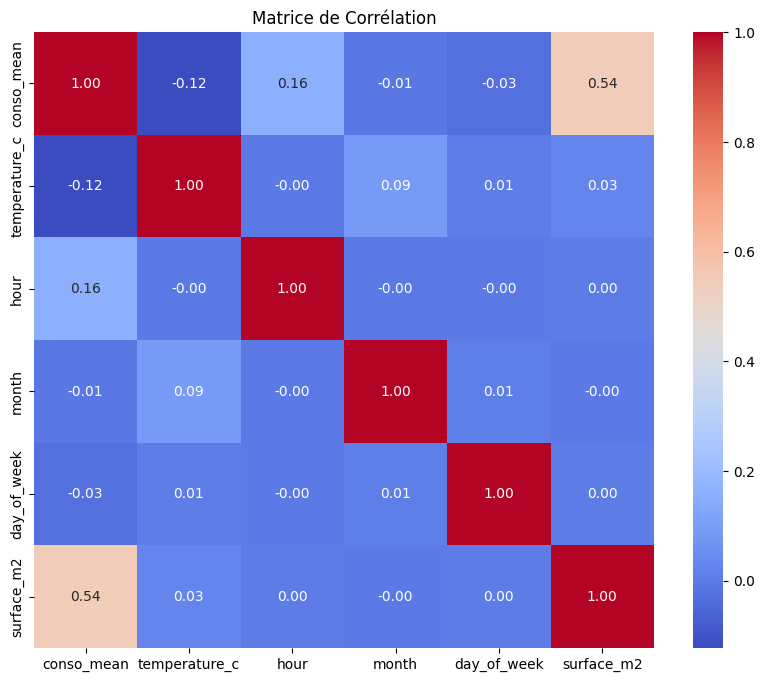

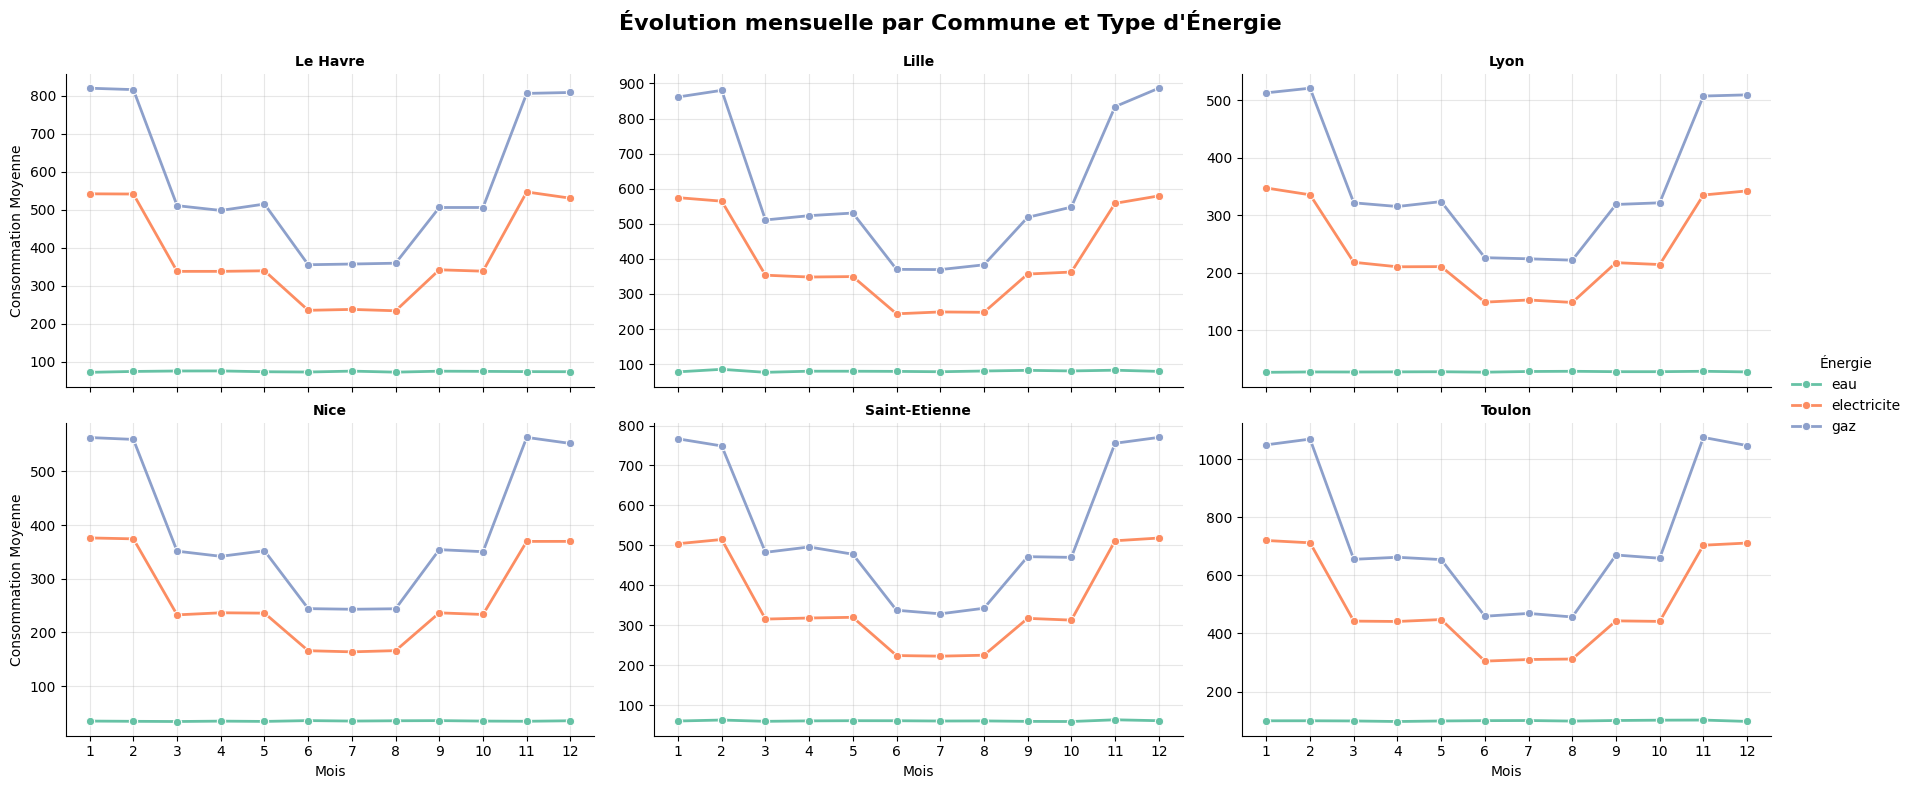

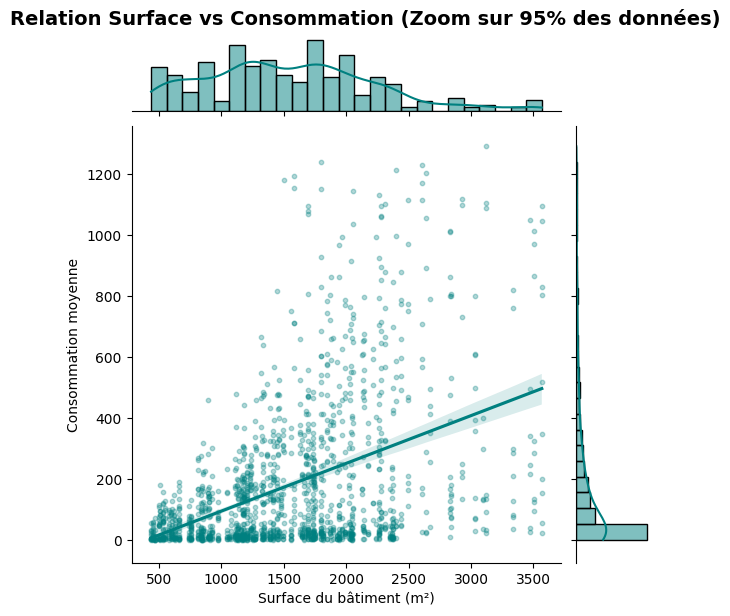

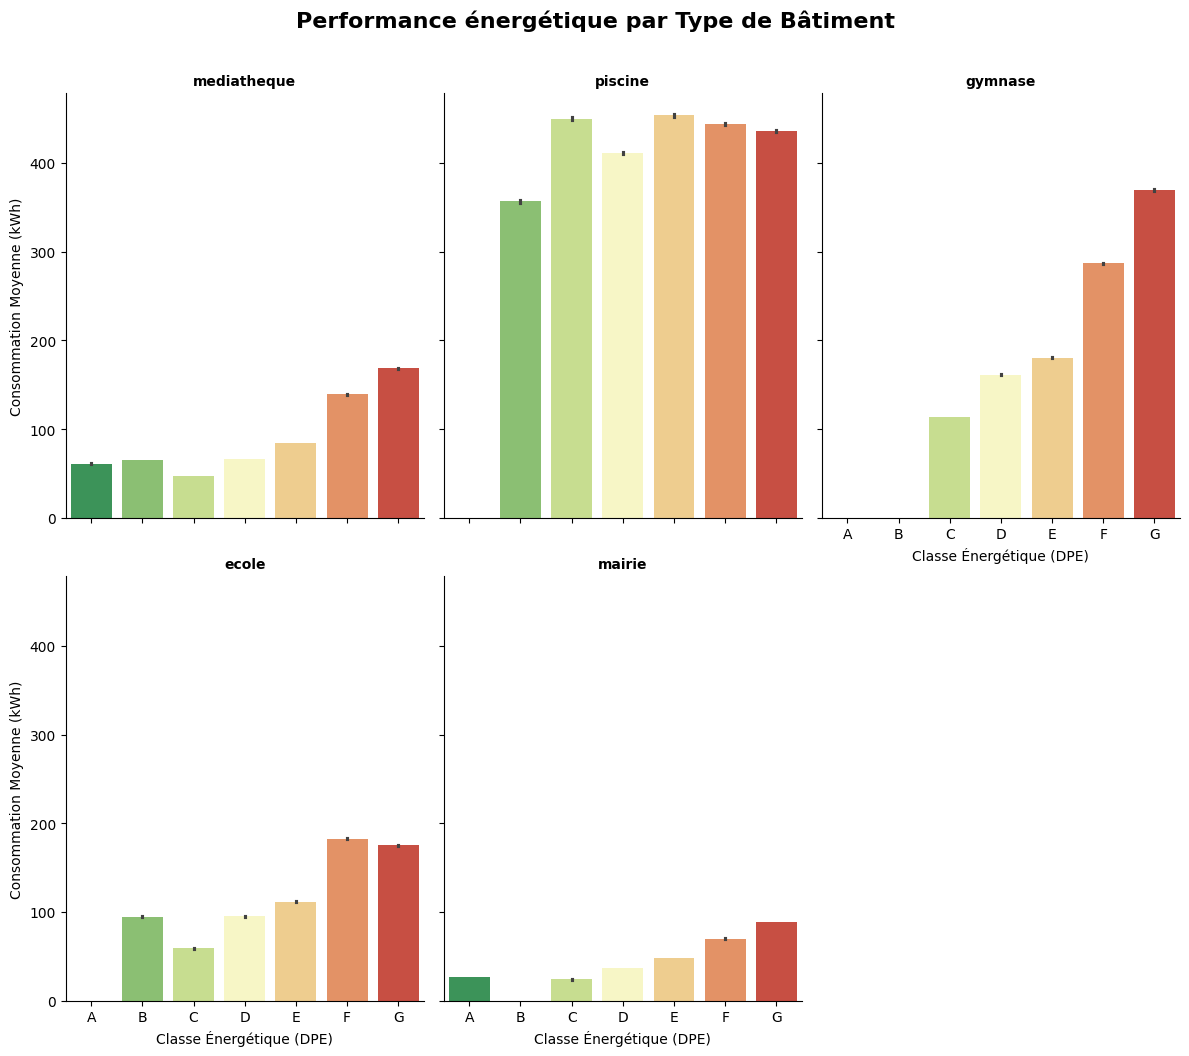

In [33]:
# --- GRAPHIQUE 1 : PAIRPLOT ---
g1 = sns.pairplot(df_pp_final.dropna(), hue='season', kind="reg", diag_kind="kde")
g1.fig.suptitle("Pairplot des consommations par saison", y=1.02)
g1.savefig("../output/figures/01_pairplot.png", dpi=300, bbox_inches='tight')

# --- GRAPHIQUE 2 : VIOLIN PLOT ---
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_conso_electrique, 
               x="type", 
               y="conso_mean", 
               palette="muted", 
               inner="quartile"
               )
plt.title("Consommation électrique par type de bâtiment", fontsize=14, fontweight="bold")
plt.xlabel("Type de bâtiment")
plt.ylabel("Consommation électrique")



# --- GRAPHIQUE 3 : HEATMAP ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de Corrélation")
plt.savefig("../output/figures/03_heatmap.png", dpi=300)

# --- GRAPHIQUE 4 : FACETGRID ---
g4 = sns.FacetGrid(df_plot, col="commune", hue="type_energie", 
                  col_wrap=3, height=4, aspect=1.5, sharey=False,
                  palette="Set2")


g4.map(sns.lineplot, "month", "conso_mean", marker="o", linewidth=2)

g4.set_axis_labels("Mois", "Consommation Moyenne")
g4.set_titles(col_template="{col_name}", fontweight='bold')
g4.add_legend(title="Énergie")

for ax in g4.axes.flatten():
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

plt.subplots_adjust(top=0.9)
g4.fig.suptitle("Évolution mensuelle par Commune et Type d'Énergie", fontsize=16, fontweight='bold')
g4.savefig("../output/figures/04_evolution_communes.png", dpi=300)

# --- GRAPHIQUE 5 : JOINTPLOT ---
g5 = sns.jointplot(
    data=df_filtered.sample(min(1500, len(df_filtered))),
    x="surface_m2",
    y="conso_mean",
    kind="reg", 
    color="teal",
    marginal_kws=dict(bins=25, fill=True),
    joint_kws={'scatter_kws': {'alpha': 0.3, 's': 10}}
)
g5.fig.suptitle("Relation Surface vs Consommation (Zoom sur 95% des données)", y=1.02, fontsize=14, fontweight="bold")
g5.ax_joint.set_xlabel("Surface du bâtiment (m²)")
g5.ax_joint.set_ylabel("Consommation moyenne")
g5.savefig("../output/figures/05_surface_vs_conso.png", dpi=300)



# --- GRAPHIQUE 6 : CATPLOT ---
g6 = sns.catplot(
    data=df_cat, 
    x="classe_energetique", 
    y="conso_mean", 
    col="type", 
    kind="bar",
    order=ordre_dpe,
    palette="RdYlGn_r",
    height=5, 
    aspect=0.8,
    col_wrap=3 
)
g6.set_axis_labels("Classe Énergétique (DPE)", "Consommation Moyenne (kWh)")
g6.set_titles("{col_name}", fontweight='bold')
g6.fig.suptitle("Performance énergétique par Type de Bâtiment", y=1.05, fontsize=16, fontweight='bold')
g6.savefig("../output/figures/06_dpe_par_batiment.png", dpi=300)